# Manage Package Versions

In [ ]:
# Scikit-Learn Colab Update

# !pip3 install -U scikit-learn

In [ ]:
# Check Scikit-Learn Version

# !python3 -m pip show scikit-learn

In [ ]:
# !python3 -m pip freeze

# Imports

In [2]:
# import pycuda.driver as cuda
# import pycuda.autoinit
# from pycuda.compiler import SourceModule

# %load_ext autoreload
# %autoreload 2

import os
import errno
import shutil
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

import tensorflow as tf
import cv2

import sklearn
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import (cross_validate, StratifiedKFold, 
                                     train_test_split, learning_curve, 
                                     GridSearchCV)
from sklearn.metrics import (accuracy_score, plot_roc_curve, auc, 
                               confusion_matrix, roc_auc_score, roc_curve)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive


'/device:GPU:0'

# Manage Files

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
%%bash

# Creating data directory
mkdir data

# Copying, unzipping and removing zip files
cp /content/drive/MyDrive/sdw_classification/datasets/not_processed/metal.zip /content/
unzip -q /content/metal.zip -d /content/data/ 
rm /content/metal.zip

cp /content/drive/MyDrive/sdw_classification/datasets/not_processed/cardboard.zip /content/
unzip -q /content/cardboard.zip -d /content/data
rm /content/cardboard.zip

# Preprocessing


In [3]:
%%bash 

# Create directory containing model
mkdir -p trainer
touch trainer/__init__.py

In [10]:
import os

folder = 'data'

for filename in os.listdir(folder):
  
  for image in os.listdir(os.path.join(folder,filename)):
    print(image)
    break

metal
metal91.jpg
cardboard
cardboard133.jpg


In [26]:
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

def get_image_paths(folder = 'data/'):

  image_paths = []
  labels = []
  cont = 0

  for filename in os.listdir(folder):
    dir_path = os.path.join(folder, filename)
    paths = [os.path.join(dir_path,image) for image in os.listdir(dir_path)]
    label = [cont]*len(im_path)

    image_paths += paths
    labels += label

  return image_paths, labels

# Helper functions
def wrap_int64(value):
  return tf.train.Feature(int64_list = tf.train.Int64List(value = [value]))

def wrap_bytes(value):
  return tf.train.Feature(bytes_list = tf.train.BytesList(value = [value]))

# TFRecords Function
def convert(image_paths, labels, out_path):
  print('Converting' + out_path)

  num_images = len(image_paths)

  with tf.python_io.TFRecordWriter(out_path) as writer:
    for i, (path, label) in enumerate(zip(image_paths, labels)):

    # Load the image file using the matplotlib imread fucntion
    img = plt.imread(path)

    # Convert image to raw bytes
    img_bytes = img.tostring()

    # Create a dict with the data we want to save in the TFRecord file.
    data = {'image':wrap_bytes(img_bytes), 'label': wrap_int64(label)}

    # Wrap the data as Tensorflow Features
    feature = tf.train.Feature(feature = data)

    # Wrap again as Tensorflow Example
    example = tf.train.Example(features = feature)
    
    # Serialize the data
    serialized = example.SerializeToString()

    # Write the Serialized data to the TFRecord file
    writer.write(serialized)



def load_images(folder = "data/"):
  # images = {}

  images_path = []

  for filename in os.listdir(folder):
    # category = []
    path = os.path.join(folder,filename)

    paths = [os.path.join(path,image) for image in os.listdir(path)]
    images_path += paths
    # for image in os.listdir(path):
    #   img = cv2.imread(os.path.join(path,image),0)

    #   if img is not None:
    #     category.append(img)

    # images[filename] = category

  return images_path

In [23]:
images = load_images()


In [24]:
images

['data/metal/metal91.jpg',
 'data/metal/metal131.jpg',
 'data/metal/metal94.jpg',
 'data/metal/metal155.jpg',
 'data/metal/metal283.jpg',
 'data/metal/metal192.jpg',
 'data/metal/metal173.jpg',
 'data/metal/metal126.jpg',
 'data/metal/metal45.jpg',
 'data/metal/metal343.jpg',
 'data/metal/metal323.jpg',
 'data/metal/metal306.jpg',
 'data/metal/metal146.jpg',
 'data/metal/metal300.jpg',
 'data/metal/metal16.jpg',
 'data/metal/metal55.jpg',
 'data/metal/metal405.jpg',
 'data/metal/metal147.jpg',
 'data/metal/metal189.jpg',
 'data/metal/metal194.jpg',
 'data/metal/metal276.jpg',
 'data/metal/metal11.jpg',
 'data/metal/metal281.jpg',
 'data/metal/metal78.jpg',
 'data/metal/metal214.jpg',
 'data/metal/metal158.jpg',
 'data/metal/metal95.jpg',
 'data/metal/metal225.jpg',
 'data/metal/metal321.jpg',
 'data/metal/metal43.jpg',
 'data/metal/metal141.jpg',
 'data/metal/metal402.jpg',
 'data/metal/metal28.jpg',
 'data/metal/metal376.jpg',
 'data/metal/metal84.jpg',
 'data/metal/metal74.jpg',
 'da

In [ ]:
# %%writefile trainer/preprocess

# import tensorflow as tf


## Edges

In [ ]:
def edges(img):

  img = np.float32(tf.squeeze(img))

  # Blurring 
  blurred = cv2.bilateralFilter(img,15,150,150)

  # Edge Detection
  v = np.median(blurred)
  sigma = 0.33

  lower = int(max(0,(1-sigma)*v))
  upper = int(min(255,(1+sigma)*v))

  img = np.uint8(img)

  edged = tf.convert_to_tensor(cv2.Canny(img,lower,upper),dtype=tf.float32)
  x , y = edged.shape
  edged = tf.reshape(edged,[x,y,1])
  # edged.shape = (edged.shape[0],edged.shape[1],1)

  return edged

## Discrete Fourier Transform


In [ ]:
def dft(img):
  return tf.signal.rfft2d(img)

# Data preparation

In [ ]:
# Image Generator
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2,
                                                                  rescale = 1./255,
                                                                  preprocessing_function = edges)
dims = 30

# Processing techniques included
data_gen = image_generator.flow_from_directory(directory='data', 
                                                    target_size=(dims, dims),
                                                  color_mode = "grayscale",
                                                  save_format='webp',
                                                  batch_size = 813)

Found 813 images belonging to 2 classes.


In [ ]:
# Extracting train and test images and labels
images, label = data_gen.next()

# Converting label into a Dataframe for easier management
y = pd.DataFrame(label)

# Homogenizing sample by eliminating extra samples
c1 = sum(y[0])
c2 = len(y)-c1
num_images = int(min(c1,c2))
c1_images = images[y[y[0] == 1].index.tolist()[:num_images]]
c1_label = label[y[y[0] == 1].index.tolist()[:num_images]]
c2_images = images[y[y[0] == 0].index.tolist()[:num_images]]
c2_label = label[y[y[0] == 0].index.tolist()[:num_images]]

# Concatenating samples
balanced_images = np.concatenate((c1_images,c2_images))
balanced_label = np.concatenate((c1_label,c2_label))

# Shape dimensions
d1 = balanced_images.shape[3]

# Flattening
X = []

for i in range(0, balanced_images.shape[0]):
  image = balanced_images[i][:, :, 0]
  X_train = np.reshape(image, (1, d1*dims*dims))[0]
  X.append(X_train)

X = pd.DataFrame(X)
y = pd.DataFrame(balanced_label)

print(X.shape)
print(y.shape)
print(num_images)

(806, 900)
(806, 2)
403


# Decomposition

## PCA

In [ ]:
def applypca(X):

  pca = PCA()
  X_pca = pca.fit_transform(X)
  X_pca = pd.DataFrame(X_pca)

  return (X_pca,pca)

In [ ]:
(X_pca,pca) = applypca(X)

variance = pca.explained_variance_ratio_

suma = 0
cont = 0
while suma < 0.8:
  suma += variance[cont]
  cont += 1

X_pca80 = X_pca.iloc[:,:cont]


print(X.shape)
print(X_pca.shape)
print(X_pca80.shape)

(806, 900)
(806, 806)
(806, 252)


## NMF

In [ ]:
def applynmf(X):

  nmf = NMF(n_components = cont)
  X_nmf = nmf.fit_transform(X)
  X_nmf = pd.DataFrame(X_nmf)

  return (X_nmf,nmf)

In [ ]:
(X_nmf,nmf) = applynmf(X)

print(X.shape)
print(X_nmf.shape)

(806, 900)
(806, 252)


# Models

In [ ]:
# modelo = regresionlogistica(datos entrenamiento)




## Statsmodels

In [ ]:
x_train_const = sm.add_constant(x_train)
x_test_const = sm.add_constant(x_test)

# Crear y entrenar modelos con dataset
logistic_sm_ind = sm.Logit(y_train,x_train_const)
results_ind = logistic_sm_ind.fit_regularized()

/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.4074470093314097e-10
            Iterations: 60
            Function evaluations: 104
            Gradient evaluations: 60


In [ ]:
results_ind

In [ ]:
params = x_test
params['y'] = y_test

In [ ]:
logistic_sm_ind.score(y_test)

ValueError: ignored

### Independencia y Significancia

In [ ]:
def colinealidad(x_train,y_train):
  # Array donde se guardaran cada conjunto de pixeles colineales
  # encontrados en cada capa de regresion
  colineales = []

  # Array de pixeles significativos
  signif = []

  # Indice de pixeles independientes con los cuales se trabajara 
  # en cada iteracion
  ind_independientes = x_train.columns

  # Array de puntaje de la Regresion Logistica
  scores = []

  bandera = False
  while bandera == False:
    # Escoger pixeles independientes para el train sample
    x_train_const = sm.add_constant(x_train[ind_independientes])
    x_test_const = sm.add_constant(x_test[ind_independientes])

    # Crear y entrenar modelos con dataset
    logistic_sm_ind = sm.Logit(y_train,x_train_const)
    results_ind = logistic_sm_ind.fit_regularized()

    # Score del modelo
    scores.append(logistic_sm_ind.rsq)

    # Extraer pvalores y configurar numero de colineales con capa
    pvalores = results_ind.pvalues
    pvalores.drop(['const'],axis = 0, inplace = True)
    pvalores[pvalores.isna()] = 0

    # Extraer significativos y guardar indices en lista
    array_signif = pvalores[pvalores <= 0.05]
    array_signif = pd.DataFrame(array_signif.index.tolist())
    signif.append(array_signif)

    # Extraer colineales y guardar indices en lista
    col = pvalores[pvalores == 0]
    if len(col) == 0:
      bandera = True
    else:
      ind_col = pd.DataFrame(col.index.tolist())
      colineales.append(ind_col)

    # Extraer independientes y actualizar lista
    ind = pvalores[pvalores > 0]
    ind_independientes = ind.index.tolist()

  return (colineales, ind_independientes, signif)

In [ ]:
(colineales, ind_independientes, signif) = colinealidad(X,y[0])

NameError: ignored

In [ ]:
def crear_matriz(colineales, independientes, signif, dims):
  array = np.zeros(dims*dims)

  for indices in range(1,len(colineales)):
    array[colineales[indices].iloc[:,0]] = indices

  array[independientes] = -1
  array[signif[len(signif)-2][0]] = -2

  matriz_pvalores = array.reshape((dims,dims))

  return matriz_pvalores

In [ ]:
matriz_pvalores = crear_matriz(colineales, ind_independientes, signif,dims)
matriz_pvalores

array([[ 1.,  0., -1.,  0.,  0., -2.,  1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -2., -1.,  0.,  1.,  0., -2.],
       [-1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 1., -1.,  0., -1.,  0.,  1., -1.,  0., -1., -1.],
       [-1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.],
       [ 0.,  0.,  1.,  1.,  1.,  0.,  1.,  1., -1.,  1.],
       [ 0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0., -2.,  0.,  1.,  0.,  1.,  0., -2.],
       [-1., -2.,  0.,  0.,  1.,  0., -1.,  1.,  0., -2.],
       [ 0.,  1., -2.,  0.,  1.,  0.,  1.,  0., -1.,  0.]])

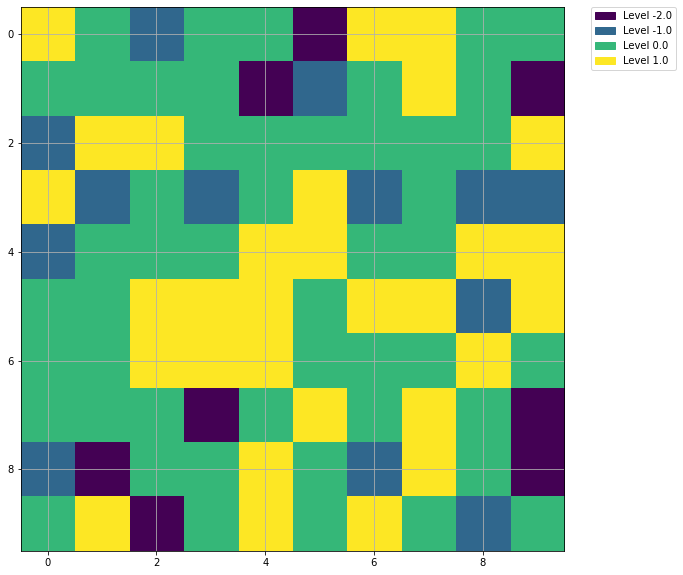

In [ ]:
plt.figure(figsize = (10,10))

values = np.unique(matriz_pvalores.ravel())

im = plt.imshow(matriz_pvalores, interpolation = 'none')

# get the colors of the values, according to the 
# colormap used by imshow
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.grid(True)
plt.show()

### Stepwise Regression

## Sklearn

### Coefficient Plot

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y[0],
                                                    test_size = 0.2,
                                                    shuffle = True)

In [ ]:
log = LogisticRegression()
log.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
coeficientes = abs(log.coef_[0])

In [ ]:
matriz = coeficientes.reshape((dims,dims))
matriz

array([[0.0005345 , 0.0058137 , 0.01005653, 0.01180501, 0.0070545 ,
        0.0081269 , 0.00958738, 0.00527523, 0.0071896 , 0.00689922],
       [0.00664023, 0.00209789, 0.00483687, 0.00595129, 0.01164557,
        0.00271672, 0.00969435, 0.0014152 , 0.0078131 , 0.00540295],
       [0.01062682, 0.00869404, 0.00431994, 0.00079411, 0.00061645,
        0.00285059, 0.00232093, 0.00089205, 0.00226361, 0.00102709],
       [0.00084139, 0.00164089, 0.0007744 , 0.00096049, 0.00148509,
        0.00470017, 0.00630697, 0.00250953, 0.007095  , 0.00098157],
       [0.00551943, 0.00051233, 0.00380059, 0.00375326, 0.00566196,
        0.00334924, 0.00151762, 0.00252606, 0.00737158, 0.00361333],
       [0.00217935, 0.00250293, 0.00757837, 0.00011648, 0.00535106,
        0.00161533, 0.00531642, 0.00560054, 0.01188251, 0.00535138],
       [0.00048288, 0.00384102, 0.00907176, 0.00162406, 0.00353421,
        0.00237052, 0.00343069, 0.00431416, 0.01359289, 0.00717934],
       [0.00061763, 0.00049107, 0.0002025

In [ ]:
def plotmatriz(matriz):
  plt.figure(figsize = (10,10))

  ax = plt.gca()
  im = ax.imshow(matriz, interpolation = 'none')

  # create an axes on the right side of ax. The width of cax will be 5%
  # of ax and the padding between cax and ax will be fixed at 0.05 inch.
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="7%", pad=0.05)

  plt.colorbar(im,cax = cax)

  plt.grid(True)
  plt.show()

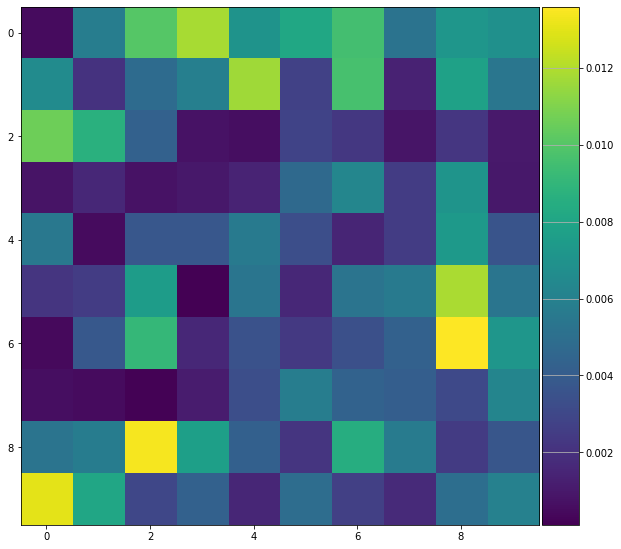

In [ ]:
plotmatriz(matriz)

### Learning Curve

In [ ]:
def plotlearningcurve(title, param_dict, score, train_sizes_dict, train_scores_mean_dict, 
                      train_scores_std_dict, test_scores_mean_dict,
                      test_scores_std_dict, path):
  
  for key in train_sizes_dict:

    train_sizes = train_sizes_dict[key]
    train_scores_mean = train_scores_mean_dict[key]
    train_scores_std = train_scores_std_dict[key]
    test_scores_mean = test_scores_mean_dict[key]
    test_scores_std = test_scores_std_dict[key]

    name = title + str(param_dict[key]['leaf_size']) + '-' + str(param_dict[key]['p'])

    tit = name + '_' + key

    plt.figure()
    plt.title(tit)
    plt.xlabel('Training examples')
    plt.ylabel(score)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1,
                        color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, 
                        color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                label="Cross-validation score")
    plt.legend(loc="best")

    # Save Figure
    filename = 'learningcurve_'+ str(tit) + '.jpg'
    plt.savefig(os.path.join(path,filename))
    
    plt.show()

In [ ]:
def learningcurve(classifier, X_dict, y, cv, param_dict, scoring, train_sizes):

  train_sizes_dict = {}
  train_scores_mean_dict = {}
  train_scores_std_dict = {}
  test_scores_mean_dict = {}
  test_scores_std_dict = {}

  for key in X_dict:

    X_train = X_dict[key]
    classifier.set_params(p = param_dict[key]['p'],
                          leaf_size = param_dict[key]['leaf_size'])

    train_sizes, train_scores, test_scores = learning_curve(classifier, 
                                  X_train, y, 
                                  cv = cv, 
                                  scoring = scoring, 
                                  train_sizes = train_sizes)

    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)

    train_sizes_dict[key] = train_sizes
    train_scores_mean_dict[key] = train_scores_mean
    train_scores_std_dict[key] = train_scores_std
    test_scores_mean_dict[key] = test_scores_mean
    test_scores_std_dict[key] = test_scores_std

  return (train_sizes_dict, train_scores_mean_dict, train_scores_std_dict,
          test_scores_mean_dict, test_scores_std_dict)

### Hyperparameter Tuning

In [ ]:
def hyper(classifier, X, y, param_grid, k, scoring):

  # Specify CV
  skf = StratifiedKFold(n_splits = k)

  clf = GridSearchCV(classifier, param_grid, cv  = skf, scoring = scoring)
  clf.fit(X_train, y[0])

  return clf.best_estimator_

In [ ]:
def hyperparametertunning(classifier, X_dict, y, param_grid, k, scoring):
  # Best Parameter dictionary
  param_dict = {}

  # Specify CV
  skf = StratifiedKFold(n_splits = k)

  # Test each dataset
  for key in X_dict:

    X_train = X_dict[key]

    clf = GridSearchCV(classifier, param_grid, cv  = skf, scoring = scoring)
    clf.fit(X_train, y[0])

    # Store parameters
    param_dict[key] = clf.best_estimator_.get_params()

  return param_dict

### Cross Validation

In [ ]:
def plotrocauc(auc_list, fpr, tpr, tprs, mean_auc, mean_fpr,
               mean_tpr, title, path):
  # Create plot
  fig, ax = plt.subplots(figsize = (10,10))

  # Plot ROC AUC Curves
  for i in range(len(fpr)):
    ax.plot(fpr[i], tpr[i], lw = 3, alpha = 0.5,
            label='ROC fold %d (area = %0.2f)' % (i, auc_list[i]))

  # Plot diagonal
  ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance',
          alpha=.8)

  # Plot Mean ROC AUC
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(auc_list)
  ax.plot(mean_fpr, mean_tpr, color='b',
          label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % 
          (mean_auc, std_auc),
          lw=2, alpha=1)
  
  # Plot Confidence Interval
  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', 
                  alpha=.2, label=r'$\pm$ 1 std. dev.')
  
  # Settings
  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title=title)
  ax.legend(loc="lower right")

  # Save Figure
  filename = 'roc_' + str(title) + '.jpg'
  plt.savefig(os.path.join(path,filename))

  plt.show()

In [ ]:
def CV(classifier, X_dict, y , k, param_dict, model_name, path):

  # Desired Metrics to include
  accuracy_dict = {}
  auc_dict = {}

  # Creating Stratified Fold for integration with CV
  skf = StratifiedKFold(n_splits = k)

  for key in X_dict:

    X = X_dict[key]
    classifier.set_params(p = param_dict[key]['p'],
                          leaf_size = param_dict[key]['leaf_size'])

    # Desired Metrics to include
    accuracy_list = []
    auc_list = []

    # Necessary Lists
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    tprs = []

    # Positive Rates
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i, (train, test) in enumerate(skf.split(X,y[0])):

      # Separate in train and test samples
      X_train = X.iloc[train,:]
      y_train = y.iloc[train,0]
      X_test = X.iloc[test,:]
      y_test = y.iloc[test,0]

      # Fitting the model
      classifier.fit(X_train,y_train)

      # Predict
      y_pred = classifier.predict(X_test)

      # Find accuracy and add it to list
      accuracy = accuracy_score(y_test,y_pred)
      accuracy_list.append(accuracy)

      # Score function
      y_score = classifier.predict_proba(X_test)[:,1]

      # ROC AUC Curve
      fpr[i], tpr[i], thresholds = roc_curve(y_test,y_score)
      auc_list.append(auc(fpr[i],tpr[i]))
      aux = np.interp(mean_fpr, fpr[i], tpr[i])
      mean_tpr += aux
      mean_tpr[0] = 0.0
      tprs.append(aux)

    # Building Mean ROC AUC Curve
    mean_tpr /= k
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    name = model_name + str(param_dict[key]['leaf_size']) + '-' + str(param_dict[key]['p'])

    title = name + '_' + key

    plotrocauc(auc_list,fpr,tpr,tprs,mean_auc,mean_fpr,mean_tpr,title,path)

    # Add lists to dictionaries
    accuracy_dict[key] = accuracy_list
    auc_dict[key] = auc_list

  return (accuracy_dict, auc_dict)

In [ ]:
def CV2(classifier, X_dict, y , k1, k2, param_grid, scoring, model_name,  path):

  # Desired Metrics to include
  accuracy_dict = {}
  auc_dict = {}

  # Creating Stratified Fold for integration with CV
  skf = StratifiedKFold(n_splits = k1)

  # Iteration for each dataset
  for key in X_dict:

    X = X_dict[key]

    # Desired Metrics to include
    accuracy_list = []
    auc_list = []

    # Necessary Lists
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    tprs = []

    # Positive Rates
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # CV for each split
    for i, (train, test) in enumerate(skf.split(X,y[0])):

      # Separate in train and test samples
      X_train = X.iloc[train,:]
      y_train = y.iloc[train,0]
      X_test = X.iloc[test,:]
      y_test = y.iloc[test,0]

      # Hyperparameter tunning
      best_clf = hyper(classifier, X_train, y_train, param_grid, k2, scoring)
      classifier = best_clf

      # Predict
      y_pred = classifier.predict(X_test)

      # Find accuracy and add it to list
      accuracy = accuracy_score(y_test,y_pred)
      accuracy_list.append(accuracy)

      # Score function
      y_score = classifier.predict_proba(X_test)[:,1]

      # ROC AUC Curve
      fpr[i], tpr[i], thresholds = roc_curve(y_test,y_score)
      auc_list.append(auc(fpr[i],tpr[i]))
      aux = np.interp(mean_fpr, fpr[i], tpr[i])
      mean_tpr += aux
      mean_tpr[0] = 0.0
      tprs.append(aux)
    
    # Building Mean ROC AUC Curve
    mean_tpr /= k
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    name = model_name # + str(param_dict[key]['leaf_size']) + '-' + str(param_dict[key]['p'])

    title = name + '_' + key

    plotrocauc(auc_list,fpr,tpr,tprs,mean_auc,mean_fpr,mean_tpr,title,path)

    # Add lists to dictionaries
    accuracy_dict[key] = accuracy_list
    auc_dict[key] = auc_list

  return accuracy_dict, auc_dict

### Managing results


In [ ]:
def storeresults(results,keys,model_name, param_dict):
  # Creating Dataframe that contains results
  df = pd.DataFrame({'Model':str,'Dataset':str,
                          'Mean_Accuracy':float,
                          'STD_Accuracy':float,'Mean_AUC':float,
                          'STD_AUC':float},index = [0])

  for key in keys:

    # Extract list
    accuracy = results[0][key]
    auc = results[1][key]

    # Extract Statistic
    accuracy_mean = np.mean(accuracy)
    accuracy_std = np.std(accuracy)
    auc_mean = np.mean(auc)
    auc_std = np.std(auc)

    name = model_name + str(param_dict[key]['leaf_size']) + '-' + str(param_dict[key]['p'])
    
    df = df.append({'Model':name,'Dataset':key,
                          'Mean_Accuracy':accuracy_mean,
                          'STD_Accuracy':accuracy_std,
                          'Mean_AUC':auc_mean,
                          'STD_AUC':auc_std},ignore_index=True)
    
  df.drop(index = 0, axis = 0, inplace = True)
    
  return df

In [ ]:
def copytree(dir, src, dst, symlinks=False, ignore=None):

  dst = os.path.join(dst,dir)

  try:
      os.mkdir(dst)
  except OSError as e:
      if e.errno == errno.EEXIST:
          print('Directory already exist')
      else:
          raise

  for item in os.listdir(src):
      s = os.path.join(src, item)
      d = os.path.join(dst, item)
      if os.path.isdir(s):
          shutil.copytree(s, d, symlinks, ignore)
      else:
          shutil.copy2(s, d)

### Model

In [ ]:
# Create Directory
root = 'experiments/'
destination = '/content/drive/MyDrive/sdw_classification/experiments/KNN'

try:
    os.mkdir(root)
except OSError as e:
    if e.errno == errno.EEXIST:
        print('Directory already exist')
    else:
        raise

# Create Experiment Directory
experiment = str(input('Type Experiment Name: '))
path = root + experiment
try:
    os.mkdir(path)
except OSError as e:
    if e.errno == errno.EEXIST:
        print('Directory already exist')
    else:
        raise
model_name = str(input('Type Model Name: '))

# Create training dictionary
X_dict = {'Regular':X,'PCA':X_pca,'PCA80':X_pca80,'NMF':X_nmf}

Directory already exist
Type Experiment Name: tunededgesrescale50
Type Model Name: KNN


#### Hyperparameter Tunning

In [ ]:
%%capture

# Classifier
model = KNeighborsClassifier()

# # Create parameter grid Logistic
# penalty = ['l1','l2','elasticnet','none']
# C = np.logspace(0,4,10)
# hyperparameters = dict(C = C,penalty = penalty)

# Create parameter grid KNN
p = [1,2]
leaf_size = list(range(1,25))
hyperparameters = dict(p = p,leaf_size = leaf_size)

param_dict = hyperparametertunning(model, X_dict, y, hyperparameters, 10, 'roc_auc')

#### Learning Curve

In [ ]:
%%capture
(train_sizes_dict, train_scores_mean_dict, train_scores_std_dict,
  test_scores_mean_dict, 
  test_scores_std_dict) = learningcurve(model, X_dict, y[0], 
                                        10, param_dict, 'accuracy', np.linspace(0.1,1,50))

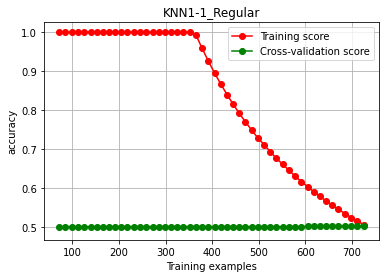

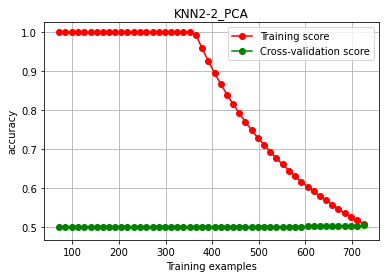

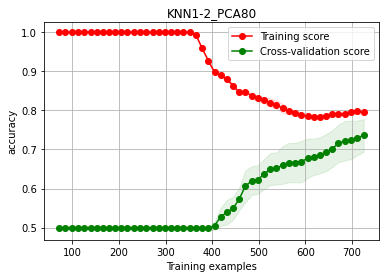

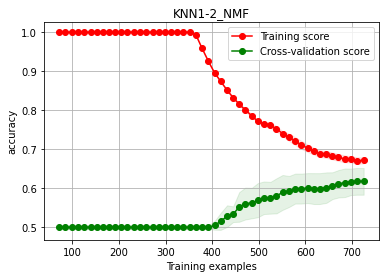

In [ ]:
plotlearningcurve(model_name, param_dict, 'accuracy', train_sizes_dict, train_scores_mean_dict, 
                  train_scores_std_dict, test_scores_mean_dict,  
                  test_scores_std_dict, path)

#### Cross Validation

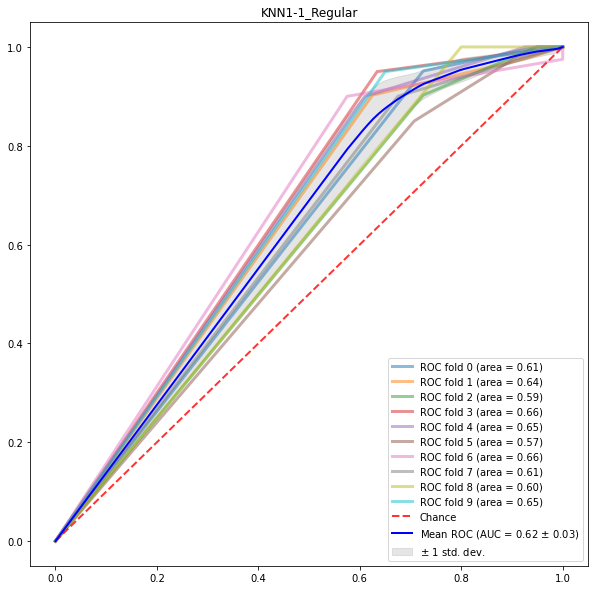

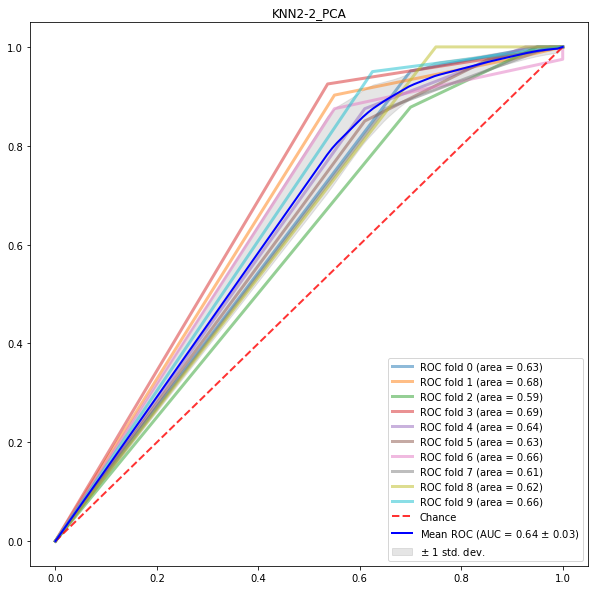

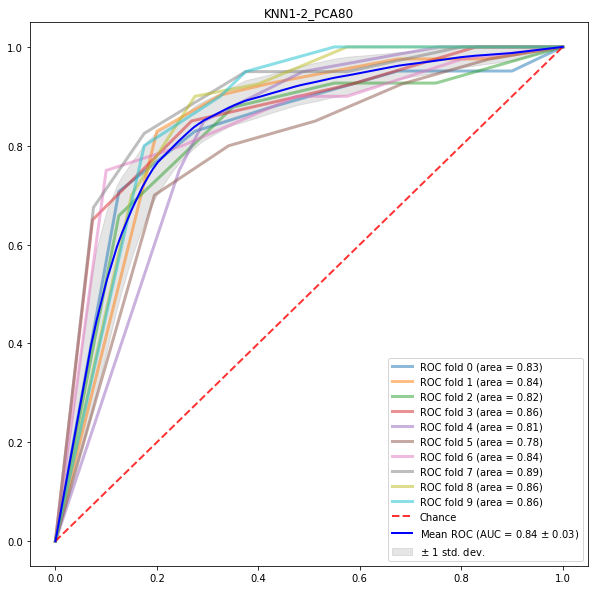

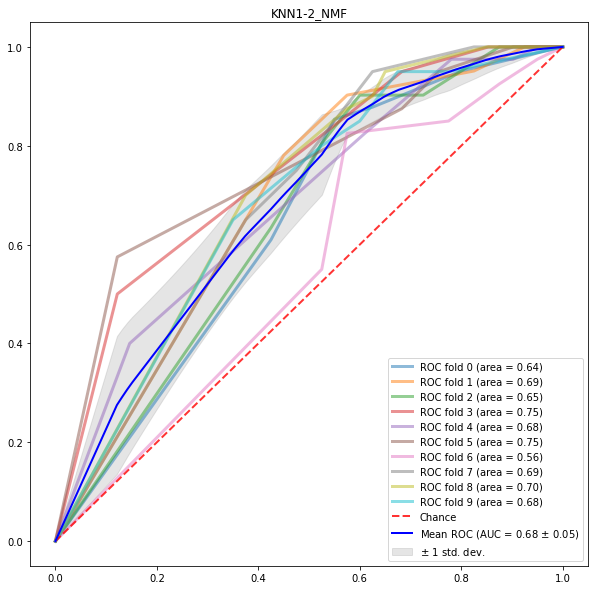

In [ ]:
(accuracy_dict, auc_dict) = CV(model, X_dict, y , 10, param_dict, model_name, path)

In [ ]:
results = [accuracy_dict, auc_dict]
df = storeresults(results,accuracy_dict.keys(),model_name, param_dict)

df

,Model,Dataset,Mean_Accuracy,STD_Accuracy,Mean_AUC,STD_AUC
1,KNN1-1,Regular,0.502469,0.0104027,0.624469,0.0283059
2,KNN2-2,PCA,0.503704,0.0114489,0.641057,0.0292443
3,KNN1-2,PCA80,0.735864,0.0417695,0.838854,0.0296485
4,KNN1-2,NMF,0.617855,0.0343087,0.678886,0.0528494


# Storing Results

In [ ]:
file_name = str(input('Enter the filename: '))
comment = str(input('Enter the experiment description:'))

df.to_csv(os.path.join(path,file_name + '.csv'))

np.savetxt(os.path.join(path,file_name + '.txt'),[comment], fmt = '%10s')

copytree(experiment,path,destination)

Enter the filename: tunededgesrescale50
Enter the experiment description:347 NMF fixed components


# Manage Files

In [ ]:
def remove_folders():
  
  # Rename directories
  os.rename('data/cardboard','data/cardboardprocessed')
  os.rename('data/metal','data/metalprocessed')

  # Ziping the folders
  shutil.make_archive('cardboardprocessed','zip','data/cardboardprocessed')
  shutil.make_archive('metalprocessed','zip','data/metalprocessed')

  # Copying zip folders
  shutil.copy('cardboardprocessed.zip','/content/drive/MyDrive/sdw_classification/datasets/compressed')
  shutil.copy('metalprocessed.zip','/content/drive/MyDrive/sdw_classification/datasets/compressed')

  # Removing folders
  os.remove('cardboardprocessed.zip')
  os.remove('metalprocessed.zip')
  shutil.rmtree('data')
  shutil.rmtree('train')
  shutil.rmtree('test')

In [ ]:
remove_folders()

FileNotFoundError: ignored

# Old Functions

Text(0.5, 1.05, 'Correlation Matrix')

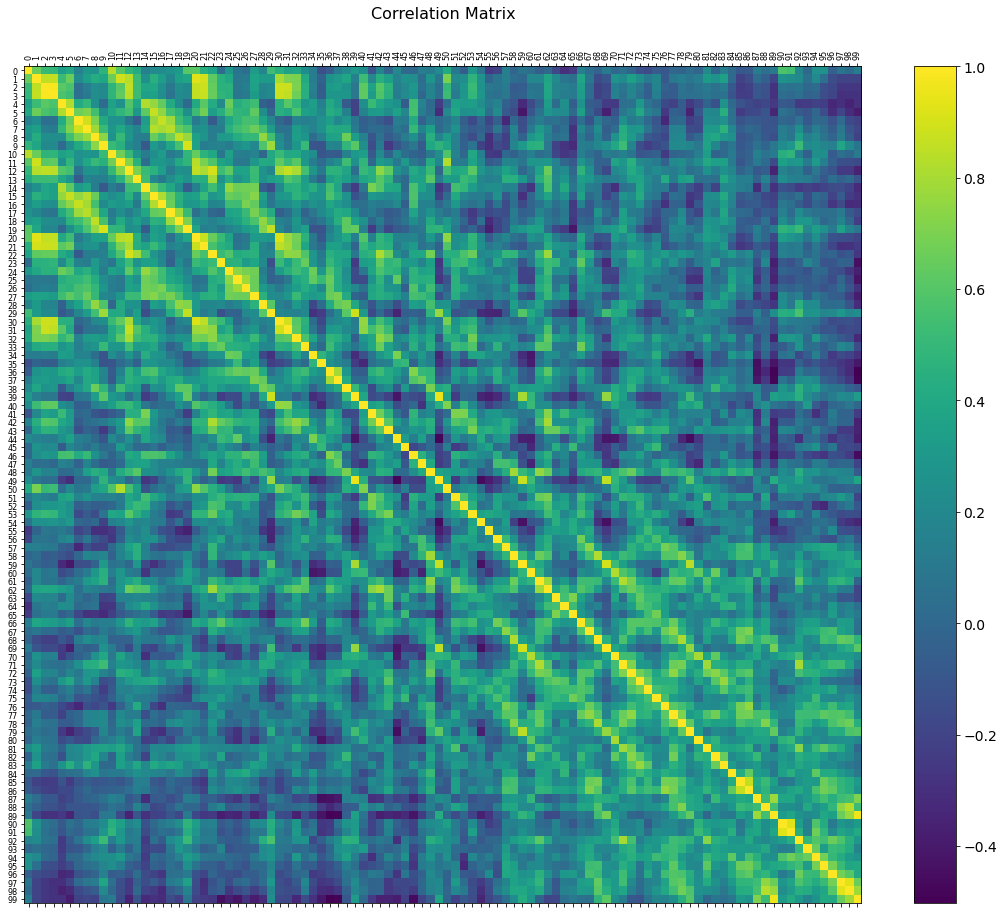

In [ ]:
f = plt.figure(figsize=(19, 15))
plt.matshow(x_train.corr(), fignum=f.number)
plt.xticks(range(x_train.shape[1]), x_train.columns, fontsize=8, rotation=90)
plt.yticks(range(x_train.shape[1]), x_train.columns, fontsize=8)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [ ]:
# def CV(classifier,X,y,k):
#   # Desired Metrics to include
#   accuracy_list = []
#   auc_list = []

#   # Necessary Lists
#   mean_tpr = 0.0
#   mean_fpr = np.linspace(0, 1, 100)
#   all_tpr = []
#   tprs = []

#   # Creating Stratified Fold for integration with CV
#   skf = StratifiedKFold(n_splits = k)

#   # Positive Rates
#   fpr = dict()
#   tpr = dict()
#   roc_auc = dict()
#   for i, (train, test) in enumerate(skf.split(X,y[0])):

#     # Separate in train and test samples
#     X_train = X.iloc[train,:]
#     y_train = y.iloc[train,0]
#     X_test = X.iloc[test,:]
#     y_test = y.iloc[test,0]

#     # Fitting the model
#     classifier.fit(X_train,y_train)

#     # Score function
#     y_score = classifier.predict_proba(X_test)[:,1]

#     # ROC AUC Curve
#     fpr[i], tpr[i], thresholds = roc_curve(y_test,y_score)
#     auc_list.append(auc(fpr[i],tpr[i]))
#     aux = np.interp(mean_fpr, fpr[i], tpr[i])
#     mean_tpr += aux
#     mean_tpr[0] = 0.0
#     tprs.append(aux)

#   # Building Mean ROC AUC Curve
#   mean_tpr /= k
#   mean_tpr[-1] = 1.0
#   mean_auc = auc(mean_fpr, mean_tpr)

#   return (accuracy_list, auc_list, fpr, tpr, tprs, mean_auc,
#           mean_fpr, mean_tpr)